# Amazon_reviews_sentiment_analysis
## NLP project using LSTM
### The aim is to predict positive or negative sentiment of user towards the product on the basis of review (text) given

## Importing Data

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  !pip uninstall tb-nightly tensorboardX tensorboardX
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf

import os
import datetime
import tensorflow_datasets as tfds

%load_ext tensorboard

Uninstalling tb-nightly-2.3.0a20200605:
  Would remove:
    /usr/local/bin/tensorboard
    /usr/local/lib/python3.6/dist-packages/tb_nightly-2.3.0a20200605.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorboard/*
Proceed (y/n)? n


### Imporing Mobile_Electronics reviews 

In [8]:
dataset, info = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', with_info=True)

train_dataset=dataset['train']

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0.incompleteL12OWT/amazon_us_reviews-train.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet



Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0. Subsequent calls will reuse this data.


In [9]:
info

tfds.core.DatasetInfo(
    name='amazon_us_reviews',
    version=0.1.0,
    description='Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promotional intent or bias in reviews.

Over 130+ million cus

### For the project, 'review_body' is the independent feature and 'star_rating' (converted to sentiment) is the target feature

In [10]:
print(train_dataset)

<DatasetV1Adapter shapes: {data: {customer_id: (), helpful_votes: (), marketplace: (), product_category: (), product_id: (), product_parent: (), product_title: (), review_body: (), review_date: (), review_headline: (), review_id: (), star_rating: (), total_votes: (), verified_purchase: (), vine: ()}}, types: {data: {customer_id: tf.string, helpful_votes: tf.int32, marketplace: tf.string, product_category: tf.string, product_id: tf.string, product_parent: tf.string, product_title: tf.string, review_body: tf.string, review_date: tf.string, review_headline: tf.string, review_id: tf.string, star_rating: tf.int32, total_votes: tf.int32, verified_purchase: tf.int64, vine: tf.int64}}>


In [11]:
len(list(train_dataset))

104975

In [ ]:
buffer_size=30000
batch_size=128

In [ ]:
train_dataset=train_dataset.shuffle(buffer_size,reshuffle_each_iteration=False)

In [13]:
for reviews in train_dataset.take(2):
  print(reviews)

{'data': {'customer_id': <tf.Tensor: shape=(), dtype=string, numpy=b'20980074'>, 'helpful_votes': <tf.Tensor: shape=(), dtype=int32, numpy=0>, 'marketplace': <tf.Tensor: shape=(), dtype=string, numpy=b'US'>, 'product_category': <tf.Tensor: shape=(), dtype=string, numpy=b'Mobile_Electronics'>, 'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'B00D1847NE'>, 'product_parent': <tf.Tensor: shape=(), dtype=string, numpy=b'274617424'>, 'product_title': <tf.Tensor: shape=(), dtype=string, numpy=b'Teenage Mutant Ninja Turtles Boombox CD Player with Text Display, AM/FM Stereo Radio, Repeat Function'>, 'review_body': <tf.Tensor: shape=(), dtype=string, numpy=b'Does not work'>, 'review_date': <tf.Tensor: shape=(), dtype=string, numpy=b'2015-01-09'>, 'review_headline': <tf.Tensor: shape=(), dtype=string, numpy=b'One Star'>, 'review_id': <tf.Tensor: shape=(), dtype=string, numpy=b'R1OVS0D6SEXPW7'>, 'star_rating': <tf.Tensor: shape=(), dtype=int32, numpy=1>, 'total_votes': <tf.Tensor: shape=(

## Coverting 'star_rating' into sentiment:
### Ratings 4 & 5 are considered as positive while the rest considered as negative

In [14]:
for reviews in train_dataset.take(10):
  review_text=reviews['data']
  print(review_text.get('review_body').numpy())
  print(review_text.get('star_rating'))
  print(tf.where(review_text.get('star_rating')>3,1,0).numpy())

b'Does not work'
tf.Tensor(1, shape=(), dtype=int32)
0
b'This is a great wiring kit i used it to set up my Pyle 2000 watt amp to 2 alpine subs and worked just fine. im not sure about the power cord and its length because my battery is in the back but the ground cord is a bit short and thats its only flaw and that why i gave it 4 stars. great kit'
tf.Tensor(4, shape=(), dtype=int32)
1
b'It works great so much faster than USB charger..Buy it! You will be glad you did!'
tf.Tensor(5, shape=(), dtype=int32)
1
b'This product was purchased to hold a monitor on a desk, which is connected to a security camera at a door of our business. It serves our purpose perfectly.'
tf.Tensor(5, shape=(), dtype=int32)
1
b"it works but it has really bad sound quality. the bass doesn't work almost at all"
tf.Tensor(3, shape=(), dtype=int32)
0
b"Excellent product !!!<br />Easy to install and performs flawlessly.<br />Video and audio is clear and GPS map pinpoints the exact vehicle location.<br />I'm thinking of

In [15]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

## Data preprocessing:
### Tokenization, encoding and padding

In [ ]:
tokenizer=tfds.features.text.Tokenizer()

vocab_set=set()


In [ ]:
for _, reviews in train_dataset.enumerate():
  review_text=reviews['data']
  reviews_tokens=tokenizer.tokenize(review_text.get('review_body').numpy())
  vocab_set.update(reviews_tokens)


In [18]:
vocab_size= len(vocab_set)
vocab_size

73738

In [ ]:
encoder=tfds.features.text.TokenTextEncoder(vocab_set)

In [22]:
for reviews in train_dataset.take(5):
  review_text=reviews['data']
  print(review_text.get('review_body').numpy())
  encoded_example=encoder.encode(review_text.get('review_body').numpy())
  print(encoded_example)

b'Does not work'
[22924, 7509, 60067]
b'This is a great wiring kit i used it to set up my Pyle 2000 watt amp to 2 alpine subs and worked just fine. im not sure about the power cord and its length because my battery is in the back but the ground cord is a bit short and thats its only flaw and that why i gave it 4 stars. great kit'
[30805, 43602, 73389, 50720, 7432, 49569, 12306, 29679, 32969, 41542, 57458, 43647, 2719, 2936, 13195, 7189, 27253, 41542, 62376, 64460, 27314, 11456, 54725, 8075, 63711, 60002, 7509, 16639, 27855, 68729, 29353, 3728, 11456, 11373, 61680, 70996, 2719, 67359, 43602, 56381, 68729, 64517, 9790, 68729, 64814, 3728, 43602, 73389, 69739, 18161, 11456, 68142, 11373, 42355, 17364, 11456, 71960, 7782, 12306, 31500, 32969, 69389, 40604, 50720, 49569]
b'It works great so much faster than USB charger..Buy it! You will be glad you did!'
[49314, 54898, 50720, 22412, 30494, 73663, 3775, 44907, 52219, 6413, 32969, 31308, 35230, 59136, 62477, 37920, 25074]
b'This product was p

In [23]:
for index in encoded_example:
  print('{} = {}'.format(index, encoder.decode([index])))

32969 = it
54898 = works
9790 = but
32969 = it
54740 = has
49098 = really
20677 = bad
52932 = sound
7026 = quality
68729 = the
50265 = bass
55075 = doesn
64489 = t
60067 = work
715 = almost
23034 = at
58471 = all


In [ ]:
def encode(text,label):
  encoded_text=encoder.encode(text.numpy())
  label=tf.where(label>3,1,0)
  return encoded_text, label

In [ ]:
def encode_map(tensor):
  text = tensor['data'].get('review_body')
  label = tensor['data'].get('star_rating')

  encoded_text, label = tf.py_function(encode, inp=[text, label],Tout=(tf.int64, tf.int32))

  encoded_text.set_shape([None])
  label.set_shape([])
  return encoded_text, label


In [ ]:
encoded_data  = train_dataset.map(encode_map)

In [33]:
for a,b in encoded_data.take(2):
  print(a.numpy())
  print(b.numpy())

[22924  7509 60067]
0
[30805 43602 73389 50720  7432 49569 12306 29679 32969 41542 57458 43647
  2719  2936 13195  7189 27253 41542 62376 64460 27314 11456 54725  8075
 63711 60002  7509 16639 27855 68729 29353  3728 11456 11373 61680 70996
  2719 67359 43602 56381 68729 64517  9790 68729 64814  3728 43602 73389
 69739 18161 11456 68142 11373 42355 17364 11456 71960  7782 12306 31500
 32969 69389 40604 50720 49569]
1


In [ ]:
take_size=10000

In [ ]:
train_data = encoded_data.skip(take_size).shuffle(buffer_size)
train_data = train_data.padded_batch(batch_size)

test_data = encoded_data.take(take_size)
test_data = test_data.padded_batch(batch_size)

In [ ]:
vocab_size+=1

In [37]:
sample_text, sample_labels = next(iter(test_data))
sample_text[0], sample_labels[0]

(<tf.Tensor: shape=(1006,), dtype=int64, numpy=array([22924,  7509, 60067, ...,     0,     0,     0])>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>)

In [42]:
for a,b in test_data.take(5):
  print(tf.unique_with_counts(b)[2].numpy())

[46 82]
[39 89]
[85 43]
[37 91]
[95 33]


## Creating the model

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 128))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
for units in [64,64]:
  model.add(tf.keras.layers.Dense(units, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [ ]:
logdir = os.path.join("/tmp/logs",datetime.datetime.now().strftime("%Y%M%D-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='/tmp/sentiment_analysis.hdf5',verbose=1, save_best_only=True)


In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         9438592   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,878,593
Trainable params: 9,878,593
Non-trainable params: 0
______________________________________________

## Training the model

In [50]:
history=model.fit(train_data, epochs=4, validation_data=test_data, callbacks=[tensorboard_callback, checkpointer])

Epoch 1/4
  1/742 [..............................] - ETA: 1:58 - loss: 0.6951 - accuracy: 0.2422WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


  2/742 [..............................] - ETA: 7:08 - loss: 0.6912 - accuracy: 0.2930WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3839s vs `on_train_batch_end` time: 0.6148s). Check your callbacks.


742/742 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.8399
Epoch 00001: val_loss improved from inf to 0.36407, saving model to /tmp/sentiment_analysis.hdf5
742/742 [==============================] - 647s 872ms/step - loss: 0.3490 - accuracy: 0.8399 - val_loss: 0.3641 - val_accuracy: 0.8143
Epoch 2/4
742/742 [==============================] - ETA: 0s - loss: 0.2883 - accuracy: 0.8769
Epoch 00002: val_loss improved from 0.36407 to 0.29348, saving model to /tmp/sentiment_analysis.hdf5
742/742 [==============================] - 647s 872ms/step - loss: 0.2883 - accuracy: 0.8769 - val_loss: 0.2935 - val_accuracy: 0.8833
Epoch 3/4
742/742 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9101
Epoch 00003: val_loss improved from 0.29348 to 0.26821, saving model to /tmp/sentiment_analysis.hdf5
742/742 [==============================] - 649s 875ms/step - loss: 0.2244 - accuracy: 0.9101 - val_loss: 0.2682 - val_accuracy: 0.8913
Epoch 4/4
742/742 [==

In [ ]:
model.save('/tmp/final_sentiment_analysis.hdf5')

In [54]:
!ls -alrt /tmp/*.hdf5

-rw-r--r-- 1 root root 118632960 Jun  5 15:34 /tmp/sentiment_analysis.hdf5
-rw-r--r-- 1 root root 118632960 Jun  5 15:56 /tmp/final_sentiment_analysis.hdf5


## Evaluating model on test data

In [58]:
eval_loss, eval_acc = model.evaluate(test_data)

79/79 [==============================] - 32s 399ms/step - loss: 0.2687 - accuracy: 0.8889


In [60]:
print('\nEval loss: {:.3f}, Eval accuracy: {:.3f}'.format(eval_loss, eval_acc))


Eval loss: 0.269, Eval accuracy: 0.889


In [61]:
for a,b in test_data.take(1):
  print(b)
  print(model.predict(a))

tf.Tensor(
[0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1
 1 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0
 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1], shape=(128,), dtype=int32)
[[-3.3299603e+00]
 [ 3.3128114e+00]
 [ 4.7570729e+00]
 [ 4.0442767e+00]
 [-2.7930877e+00]
 [ 6.0782523e+00]
 [ 5.5232077e+00]
 [-4.5762739e+00]
 [ 4.1560049e+00]
 [ 7.5610244e-01]
 [ 1.1726655e+00]
 [-5.2075424e+00]
 [-1.4311044e+00]
 [ 5.2159505e+00]
 [ 5.9527740e+00]
 [ 6.0853448e+00]
 [-2.6263347e+00]
 [ 4.1106043e+00]
 [ 3.1260715e+00]
 [ 4.1701860e+00]
 [-8.7528676e-01]
 [-4.3448453e+00]
 [-3.7962959e+00]
 [ 3.2658777e+00]
 [ 5.0794473e+00]
 [ 5.5298352e+00]
 [ 5.7178974e+00]
 [-2.0749170e-01]
 [ 4.5437737e+00]
 [-4.1338620e+00]
 [ 4.4018679e+00]
 [ 9.7859250e-03]
 [ 3.6139286e+00]
 [ 5.1386042e+00]
 [ 1.0786406e+00]
 [-4.6290011e+00]
 [ 5.0226822e+00]
 [ 2.9366055e+00]
 [ 9.5504677e-01

## Plotting losses and accuracy

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_graphs(history,metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

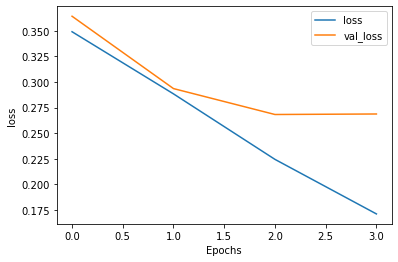

In [67]:
plot_graphs(history, 'loss')

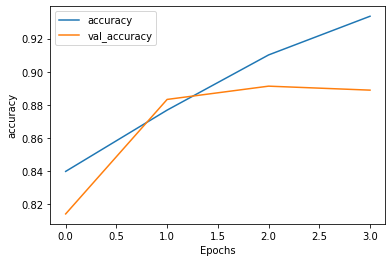

In [68]:
plot_graphs(history, 'accuracy')

## Creating functions to preprocess new review data

In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size- len(vec))
  vec.extend(zeros)
  return vec

In [ ]:
def predict_func(pred_text):
  encoded_pred_text = encoder.encode(pred_text)
  print(encoded_pred_text)
  encoded_pred_text = pad_to_size(encoded_pred_text, 32)
  print(encoded_pred_text)
  encoded_pred_text = tf.cast(encoded_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_pred_text, 0))
  return predictions

## Testing the model on new review data
### Higher the prediction value, better the positive sentiment and vice-versa

In [73]:
pred_text = ('Waste of money')
predictions = predict_func(pred_text)
print(predictions)

[41238, 42327, 50221]
[41238, 42327, 50221, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[-5.440137]]


In [74]:
pred_text = ('not a good product')
predictions = predict_func(pred_text)
print(predictions)

[7509, 73389, 71208, 65177]
[7509, 73389, 71208, 65177, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[-2.009132]]


In [75]:
pred_text = ('okayish product')
predictions = predict_func(pred_text)
print(predictions)

[46813, 65177]
[46813, 65177, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[-1.5668954]]


In [76]:
pred_text = ('you can buy at your risk')
predictions = predict_func(pred_text)
print(predictions)

[37920, 63268, 977, 23034, 32404, 28909]
[37920, 63268, 977, 23034, 32404, 28909, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[0.11881334]]


In [79]:
pred_text = ('I got the phone last week, till now its working fine. The build quality is okay. Performance at par with best in the segment')
predictions = predict_func(pred_text)
print(predictions)

[65750, 22344, 68729, 48407, 53508, 31088, 8416, 21589, 11373, 68443, 63711, 63241, 16033, 7026, 43602, 11924, 41050, 23034, 70565, 35677, 23167, 56381, 68729, 56725]
[65750, 22344, 68729, 48407, 53508, 31088, 8416, 21589, 11373, 68443, 63711, 63241, 16033, 7026, 43602, 11924, 41050, 23034, 70565, 35677, 23167, 56381, 68729, 56725, 0, 0, 0, 0, 0, 0, 0, 0]
[[4.9882536]]


In [77]:
pred_text = ('you can buy')
predictions = predict_func(pred_text)
print(predictions)

[37920, 63268, 977]
[37920, 63268, 977, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[2.5111697]]


In [80]:
pred_text = ('I got the phone last week, till now its working fine. The build quality is okay. Top notch performance')
predictions = predict_func(pred_text)
print(predictions)

[65750, 22344, 68729, 48407, 53508, 31088, 8416, 21589, 11373, 68443, 63711, 63241, 16033, 7026, 43602, 11924, 9629, 16406, 9346]
[65750, 22344, 68729, 48407, 53508, 31088, 8416, 21589, 11373, 68443, 63711, 63241, 16033, 7026, 43602, 11924, 9629, 16406, 9346, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[2.6283016]]


In [81]:
pred_text = ('not bad but also not the best one')
predictions = predict_func(pred_text)
print(predictions)

[7509, 20677, 9790, 15904, 7509, 68729, 23167, 57305]
[7509, 20677, 9790, 15904, 7509, 68729, 23167, 57305, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[-1.2156087]]


## The model is pretty good in predicting the sentiment of user about the product!